Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Skin_Data/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Skin_Data/Test/')


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [ ]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

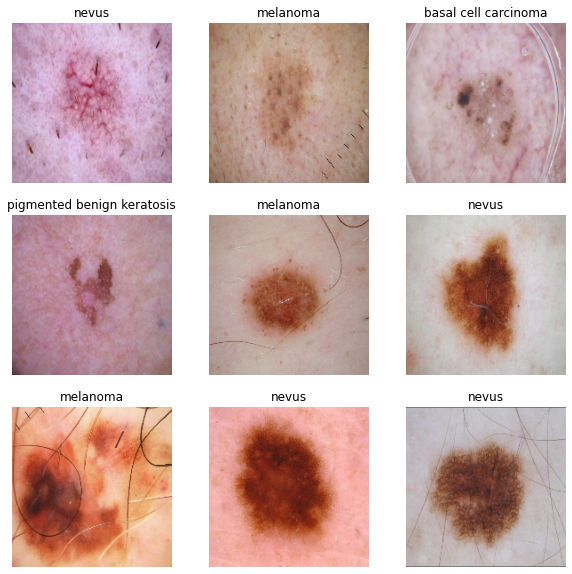

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]


In [ ]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 438s 2s/step - loss: -84031.2031 - accuracy: 0.1689 - val_loss: -86138.2266 - val_accuracy: 0.1492
Epoch 2/20
57/57 [==============================] - 4s 72ms/step - loss: -887635.5000 - accuracy: 0.1717 - val_loss: -973168.0625 - val_accuracy: 0.1492
Epoch 3/20
57/57 [==============================] - 4s 71ms/step - loss: -3186685.7500 - accuracy: 0.1717 - val_loss: -3687629.5000 - val_accuracy: 0.1492
Epoch 4/20
57/57 [==============================] - 4s 72ms/step - loss: -7799852.5000 - accuracy: 0.1717 - val_loss: -8285050.0000 - val_accuracy: 0.1492
Epoch 5/20
57/57 [==============================] - 4s 72ms/step - loss: -15529289.0000 - accuracy: 0.1717 - val_loss: -15139327.0000 - val_accuracy: 0.1492
Epoch 6/20
57/57 [==============================] - 4s 72ms/step - loss: -27002702.0000 - accuracy: 0.1717 - val_loss: -24996512.0000 - val_accuracy: 0.1492
Epoch 7/20
57/57 [==============================] - 4s 73ms/step - loss:

### Visualizing training results

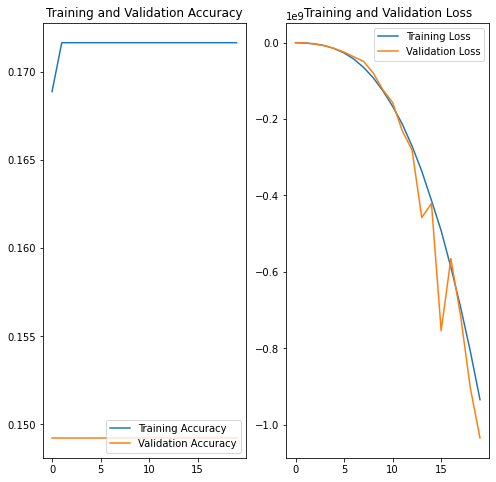

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

15/15 [==============================] - 0s 14ms/step - loss: -1034740800.0000 - accuracy: 0.1492
Accuracy:  0.17166666686534882
Validation Accuracy:  0.14922049641609192
Loss:  -1025455104.0
Validation Loss -1034740800.0


model is overfit

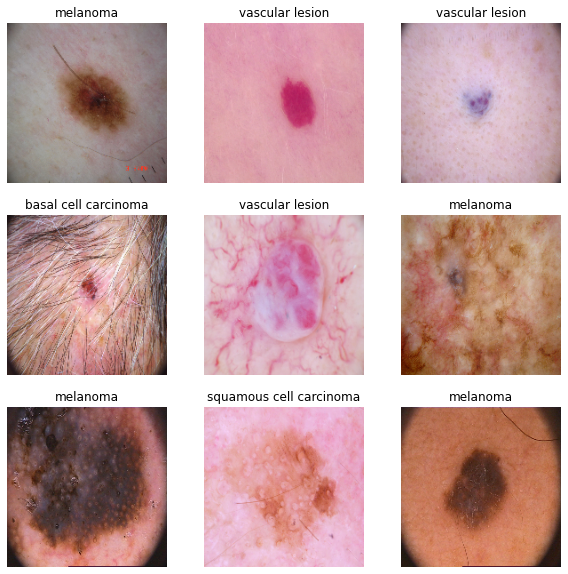

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create the model, compile and train the model


In [ ]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 8s 107ms/step - loss: 62.3327 - accuracy: 0.1600 - val_loss: 2.1777 - val_accuracy: 0.1960
Epoch 2/20
57/57 [==============================] - 5s 94ms/step - loss: 2.0391 - accuracy: 0.2139 - val_loss: 2.1477 - val_accuracy: 0.1960
Epoch 3/20
57/57 [==============================] - 5s 93ms/step - loss: 2.0343 - accuracy: 0.2056 - val_loss: 2.0748 - val_accuracy: 0.2472
Epoch 4/20
57/57 [==============================] - 5s 94ms/step - loss: 2.0233 - accuracy: 0.2344 - val_loss: 2.0701 - val_accuracy: 0.2383
Epoch 5/20
57/57 [==============================] - 5s 93ms/step - loss: 1.9841 - accuracy: 0.2567 - val_loss: 2.0756 - val_accuracy: 0.2450
Epoch 6/20
57/57 [==============================] - 5s 92ms/step - loss: 1.9323 - accuracy: 0.2828 - val_loss: 2.0876 - val_accuracy: 0.2249
Epoch 7/20
57/57 [==============================] - 5s 92ms/step - loss: 1.9372 - accuracy: 0.3039 - val_loss: 1.9541 - val_accuracy: 0.2695
Epoch 8/20
57/57 [====

### Visualizing the results

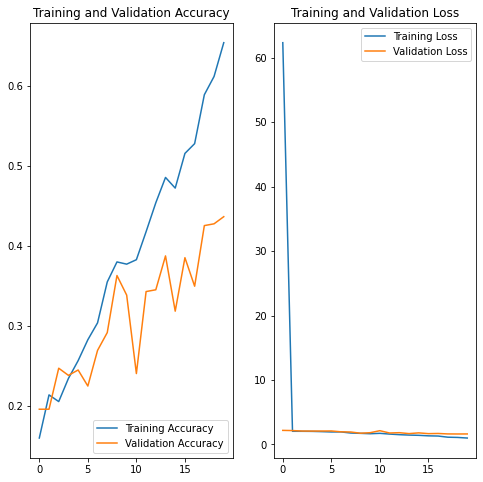

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## Your code goes here.
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

15/15 [==============================] - 0s 28ms/step - loss: 1.6244 - accuracy: 0.4365
Accuracy:  0.7105555534362793
Validation Accuracy:  0.4365256130695343
Loss:  0.8487231731414795
Validation Loss 1.6243830919265747


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

there is improvement in overfitting problem

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

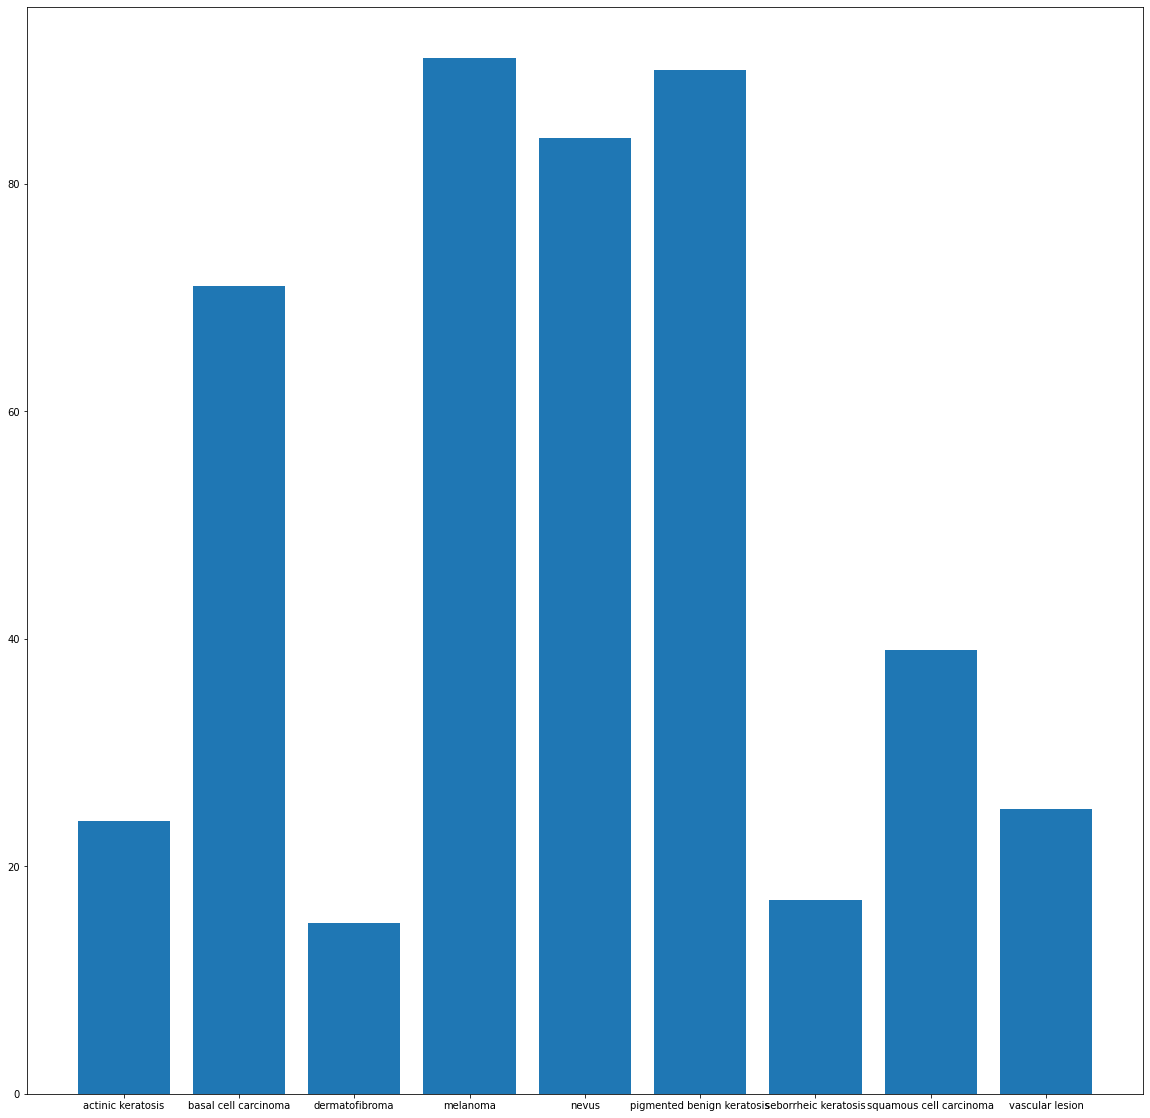

In [ ]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(8):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [ ]:
original_df['cancer_type'].value_counts()

pigmented benign keratosis    462
melanoma                      448
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: cancer_type, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Class dermatofibroma has least no of samples
#### - Which classes dominate the data in terms proportionate number of samples?

class pigmented benign keratosis , melanoma ,
basal cell carcinoma , and nevus have proportionate number of classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_Skin_Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF0A8068BD0>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF1EBB3F490>: 100%|██████████| 500/500 [00:20<00:00, 24.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF0A8059C50>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF073396750>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2314x2067 at 0x7FF0A8385250>: 100%|██████████| 500/500 [01:20<00:00,  6.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF0733AE4D0>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF0A804D490>: 100%|██████████| 500/500 [00:45<00:00, 11.01 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF073414190>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF07337CC10>: 100%|██████████| 500/500 [00:18<00:00, 26.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_6d2432f2-df49-4f95-93e5-3b991a16995b.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_317e24f8-28c5-4c2a-88c2-1e0d157b5fa0.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_4e4bc9b3-246d-41c5-95d0-7ad2e1e44309.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_44b959e9-fc54-463c-877e-d7f8d5e309e6.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_bf5ce592-87b2-460b-ab2a-724dea639b0b.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_99b6902b-a69d-4527-b301-3c7d3d4b83c0.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Data/Train/actini

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

actinic keratosis             500
vascular lesion               500
pigmented benign keratosis    500
basal cell carcinoma          500
nevus                         500
seborrheic keratosis          500
squamous cell carcinoma       500
dermatofibroma                500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/CNN_Skin_Data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
# Adding Dropout Layer
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 40s 219ms/step - loss: nan - accuracy: 0.0915 - val_loss: nan - val_accuracy: 0.0897
Epoch 2/50
169/169 [==============================] - 33s 191ms/step - loss: nan - accuracy: 0.0913 - val_loss: nan - val_accuracy: 0.0897
Epoch 3/50
169/169 [==============================] - 34s 194ms/step - loss: nan - accuracy: 0.0913 - val_loss: nan - val_accuracy: 0.0897
Epoch 4/50
169/169 [==============================] - 33s 191ms/step - loss: nan - accuracy: 0.0913 - val_loss: nan - val_accuracy: 0.0897
Epoch 5/50
169/169 [==============================] - 34s 192ms/step - loss: nan - accuracy: 0.0913 - val_loss: nan - val_accuracy: 0.0897
Epoch 6/50
169/169 [==============================] - 35s 201ms/step - loss: nan - accuracy: 0.0913 - val_loss: nan - val_accuracy: 0.0897
Epoch 7/50
169/169 [==============================] - 34s 192ms/step - loss: nan - accuracy: 0.0913 - val_loss: nan - val_accuracy: 0.0897
Epoch 8/50
169/169 [==================

#### **Todo:**  Visualize the model results

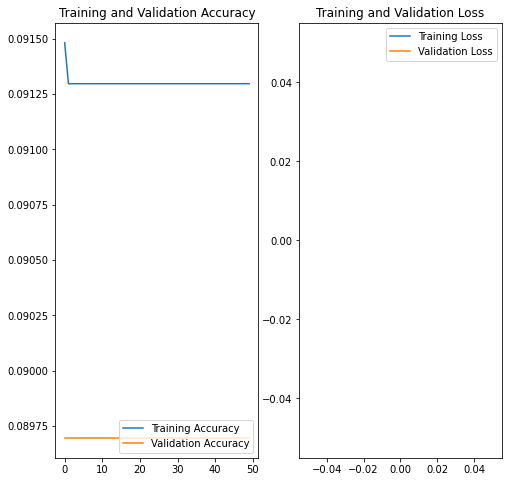

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 7s 119ms/step - loss: nan - accuracy: 0.0897
Accuracy:  0.09129629284143448
Validation Accuracy:  0.08969607204198837
Loss:  nan
Validation Loss nan


*   the class rebalance helped in reducing overfititng of the data
*   traning accuracy  is 91 %
*   validation accuracy is 89%


we used Batch Normalization and Augumentation which really helped




